<a href="https://colab.research.google.com/github/jfogarty/machine-learning-intro-workshop/blob/master/notebooks/imbalanced-data-prec-recall-vs-roc-curve.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handling highly unbalanced classes 

### When Receiver Operating Characteristics Curve (ROC Curve) should not be used, 
### Precision/Recall curve should be preferred in highly unbalanced situations

## Motivation
In this notebook, we will explore the data through initial EDA with some visualizations. Then we will hit the main point of the notebook, which is to explore ways to handle imbalanced data. We will use two methods:
1. Using the weights parameters in Sci-Kit Learn classifiers
2. Over and Undersampling (to be developed in the next version)

Finally, we will quantify and illustrate the effects of the trade off between True Positive Rate and False Positive Rate using ROC and Precision/Recall (PR) curves, and disucss **why the popular ROC curve should not be used on highly imbalanced dataset** (or in general, why I prefer PR curves over ROC).

- [From](https://www.kaggle.com/kernels/scriptcontent/1015156/notebook) by [LCT14558](https://www.kaggle.com/lct14558) in [Kaggle](https://www.kaggle.com)

Updated by [John Fogarty](https://github.com/jfogarty) for Python 3.6 and [Base2 MLI](https://github.com/base2solutions/mli) and [colab](https://colab.research.google.com) standalone evaluation.

## Imports and reading in the data

In [0]:
import pandas as pd
pd.options.display.max_colwidth = 200
pd.options.display.max_columns = 200
import numpy as np

import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict,cross_val_score,train_test_split
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,precision_recall_curve,roc_curve

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

## Credit Card Fraud Detection Dataset

### Anonymized credit card transactions labeled as fraudulent or genuine

Last Updated: 3 years ago (Version 2 of 3)
About this Dataset
The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

### Loading the dataset

An unsecured copy of the set is a .gz file within [this github repo](https://github.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection).
We'll copy the file locally. It has a .csv extension, so we'll put .gz on it.
Once the file is in our `./tmpData` directory, we'll read it into the pandas DataFrame, uncompressing on the fly.

In [0]:
import numpy as np
import requests
import shutil
import os

ds = np.DataSource()
def copyHere(URL, toPath):
    toDir, toFile = os.path.split(toPath)
    toPath = os.path.join(toDir, toFile)
    if ds.exists(URL):
        if not toFile:
            urlPrefix, toFile = os.path.split(URL)
        response = requests.get(URL, stream=True)
        if toDir:
            if not os.path.exists(toDir): 
              print(f"- Creating directory '{toDir}'.")
              os.mkdir(toDir)
        with open(toPath, 'wb') as fin: shutil.copyfileobj(response.raw, fin)
        print(f"- Copied {URL} to {toPath}.")
    else:
        print(f"** Sorry, can't copy '{URL}' to '{toPath}'.")
        exit()        

In [12]:
filename = 'creditcard.csv'
REPO     = 'https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/'
BRANCH   = 'master/'
DIR      = ''
URL      = os.path.join(REPO, BRANCH, DIR, filename)
TMPDIR   = 'tmpData'
toPath   = os.path.join(TMPDIR, filename + '.gz')
copyHere(URL, toPath)
# URL='https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcard.csv/2'


- Copied https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv to tmpData/creditcard.csv.gz.


In [13]:
import gzip
with gzip.open(toPath) as f:
    df = pd.read_csv(f)
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Is there anything obvious about fradulent transactions that we can see right off?

In [14]:
frauds = df.loc[df['Class'] > 0]
frauds.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1.00,1
6331,7526.0,0.008430,4.137837,-6.240697,6.675732,0.768307,-3.353060,-1.631735,0.154612,-2.795892,-6.187891,5.664395,-9.854485,-0.306167,-10.691196,-0.638498,-2.041974,-1.129056,0.116453,-1.934666,0.488378,0.364514,-0.608057,-0.539528,0.128940,1.488481,0.507963,0.735822,0.513574,1.00,1
6334,7535.0,0.026779,4.132464,-6.560600,6.348557,1.329666,-2.513479,-1.689102,0.303253,-3.139409,-6.045468,6.754625,-8.948179,0.702725,-10.733854,-1.379520,-1.638960,-1.746350,0.776744,-1.327357,0.587743,0.370509,-0.576752,-0.669605,-0.759908,1.605056,0.540675,0.737040,0.496699,1.00,1
6336,7543.0,0.329594,3.712889,-5.775935,6.078266,1.667359,-2.420168,-0.812891,0.133080,-2.214311,-5.134454,4.560720,-8.873748,-0.797484,-9.177166,-0.257025,-0.871688,1.313014,0.773914,-2.370599,0.269773,0.156617,-0.652450,-0.551572,-0.716522,1.415717,0.555265,0.530507,0.404474,1.00,1
6338,7551.0,0.316459,3.809076,-5.615159,6.047445,1.554026,-2.651353,-0.746579,0.055586,-2.678679,-4.959493,6.439053,-7.520117,0.386352,-9.252307,-1.365188,-0.502362,0.784427,1.494305,-1.808012,0.388307,0.208828,-0.511747,-0.583813,-0.219845,1.474753,0.491192,0.518868,0.402528,1.00,1
6427,7610.0,0.725646,2.300894,-5.329976,4.007683,-1.730411,-1.732193,-3.968593,1.063728,-0.486097,-4.624985,5.588724,-7.148243,1.680451,-6.210258,0.495282,-3.599540,-4.830324,-0.649090,2.250123,0.504646,0.589669,0.109541,0.601045,-0.364700,-1.843078,0.351909,0.594550,0.099372,1.00,1


The data has a column called 'Time', which are seconds from which the very first data observation took place. Let's convert that to hours of a day. I'm guessing the data starts at midnight and ends at midnight.

In [0]:
df['hour'] = df['Time'].apply(lambda x: np.ceil(float(x)/3600) % 24)

Seems right that we have the least transactions from 1AM to 5AM. Let's see a breakdown of our legit vs fraud transactions via a pivot table.

**Note:**
* Class 0 = Legit transactions
* Class 1 = Fruadulent transactions

In [16]:
df.pivot_table(values='Amount',index='hour',columns='Class',aggfunc='count')

Class,0,1
hour,,
0.0,10919,21
1.0,7687,6
2.0,4212,10
3.0,3269,57
4.0,3476,17
5.0,2185,23
6.0,2979,11
7.0,4093,9
8.0,7219,23


# Visualizing the data

In [0]:
def PlotHistogram(df,norm):
    bins = np.arange(df['hour'].min(),df['hour'].max()+2)
    plt.figure(figsize=(15,4))
    sns.distplot(df[df['Class']==0.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='b',
                 hist_kws={'alpha':.5},
                 label='Legit')
    sns.distplot(df[df['Class']==1.0]['hour'],
                 norm_hist=norm,
                 bins=bins,
                 kde=False,
                 color='r',
                 label='Fraud',
                 hist_kws={'alpha':.5})
    plt.xticks(range(0,24))
    plt.legend()
    plt.show()

Normalized histogram of Legit/Fraud over hour of the day


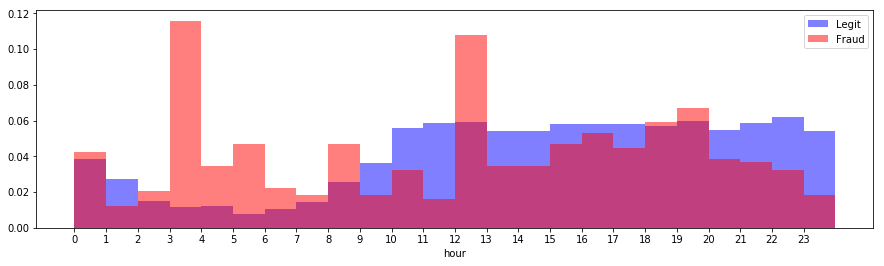

Counts histogram of Legit/Fraud over hour of the day
*you can barely see the Fraud cases since there are so few of them.


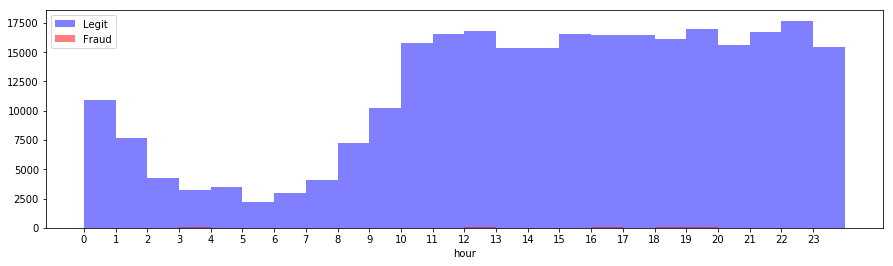

0.9917066097259521


In [18]:
start = time.time()
print('Normalized histogram of Legit/Fraud over hour of the day')
PlotHistogram(df,True)
print('Counts histogram of Legit/Fraud over hour of the day')
print('*you can barely see the Fraud cases since there are so few of them.')
PlotHistogram(df,False)
print(time.time()-start)

In [19]:
print('Fraud is {}% of our data.'.format(df['Class'].value_counts()[1] / float(df['Class'].value_counts()[0])*100))

Fraud is 0.17304750013189596% of our data.


Hour of the day seems to  have some impact on the number of Fraud cases. I'll be sure to to add the 'hour' dimension to visualizations later to further investigate its impact. 

Before we train our classifers, we need to normalize the Amount since it's on a totally different scale. The distributions are also highly skewed with a lot of statistical outliers. All Fraud cases are in the low dollar values i.e. Amount.

**We also have a HUGE class imbalance.** More on that later when we start to train classifiers.

In [0]:
mask_true = (df['Class'] == 1.0) 
mask_false = (df['Class'] == 0.0)

df['Amount'] = StandardScaler().fit_transform(df[['Amount']])

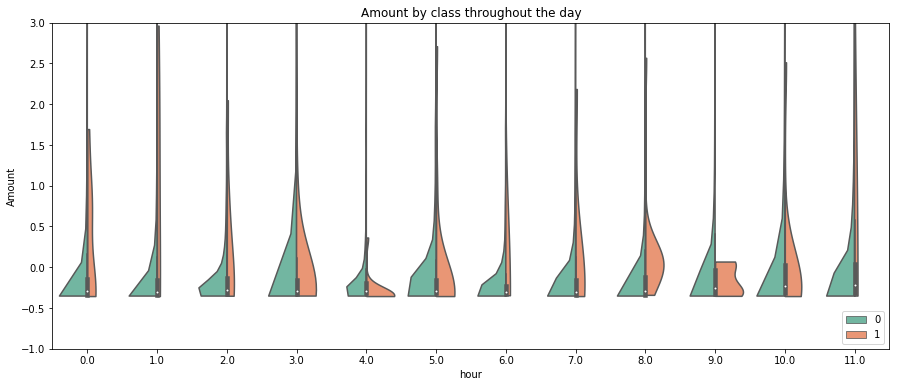

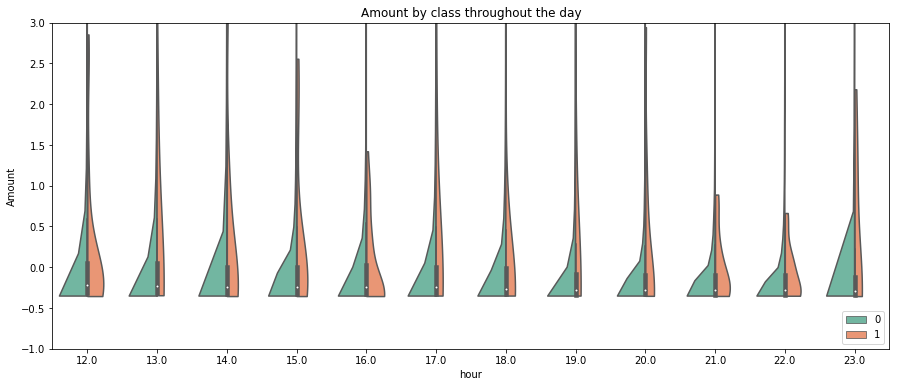

In [21]:
def PlotViolins(minHour,maxHour):
    plt.figure(figsize=(15,6))
    plt.title('Amount by class throughout the day')
    plt.ylim([-1,3.0])
    sns.violinplot(data=df[df['hour'].isin(range(minHour,maxHour+1))],x='hour',y='Amount',hue='Class',split=True,palette='Set2',cut=0)
    plt.legend(loc='lower right')
    plt.show()
PlotViolins(0,11)
PlotViolins(12,23)

Let's see how well the PCA components complement each other by looking their interactions with each other. I'm only including the first 6 components here.

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


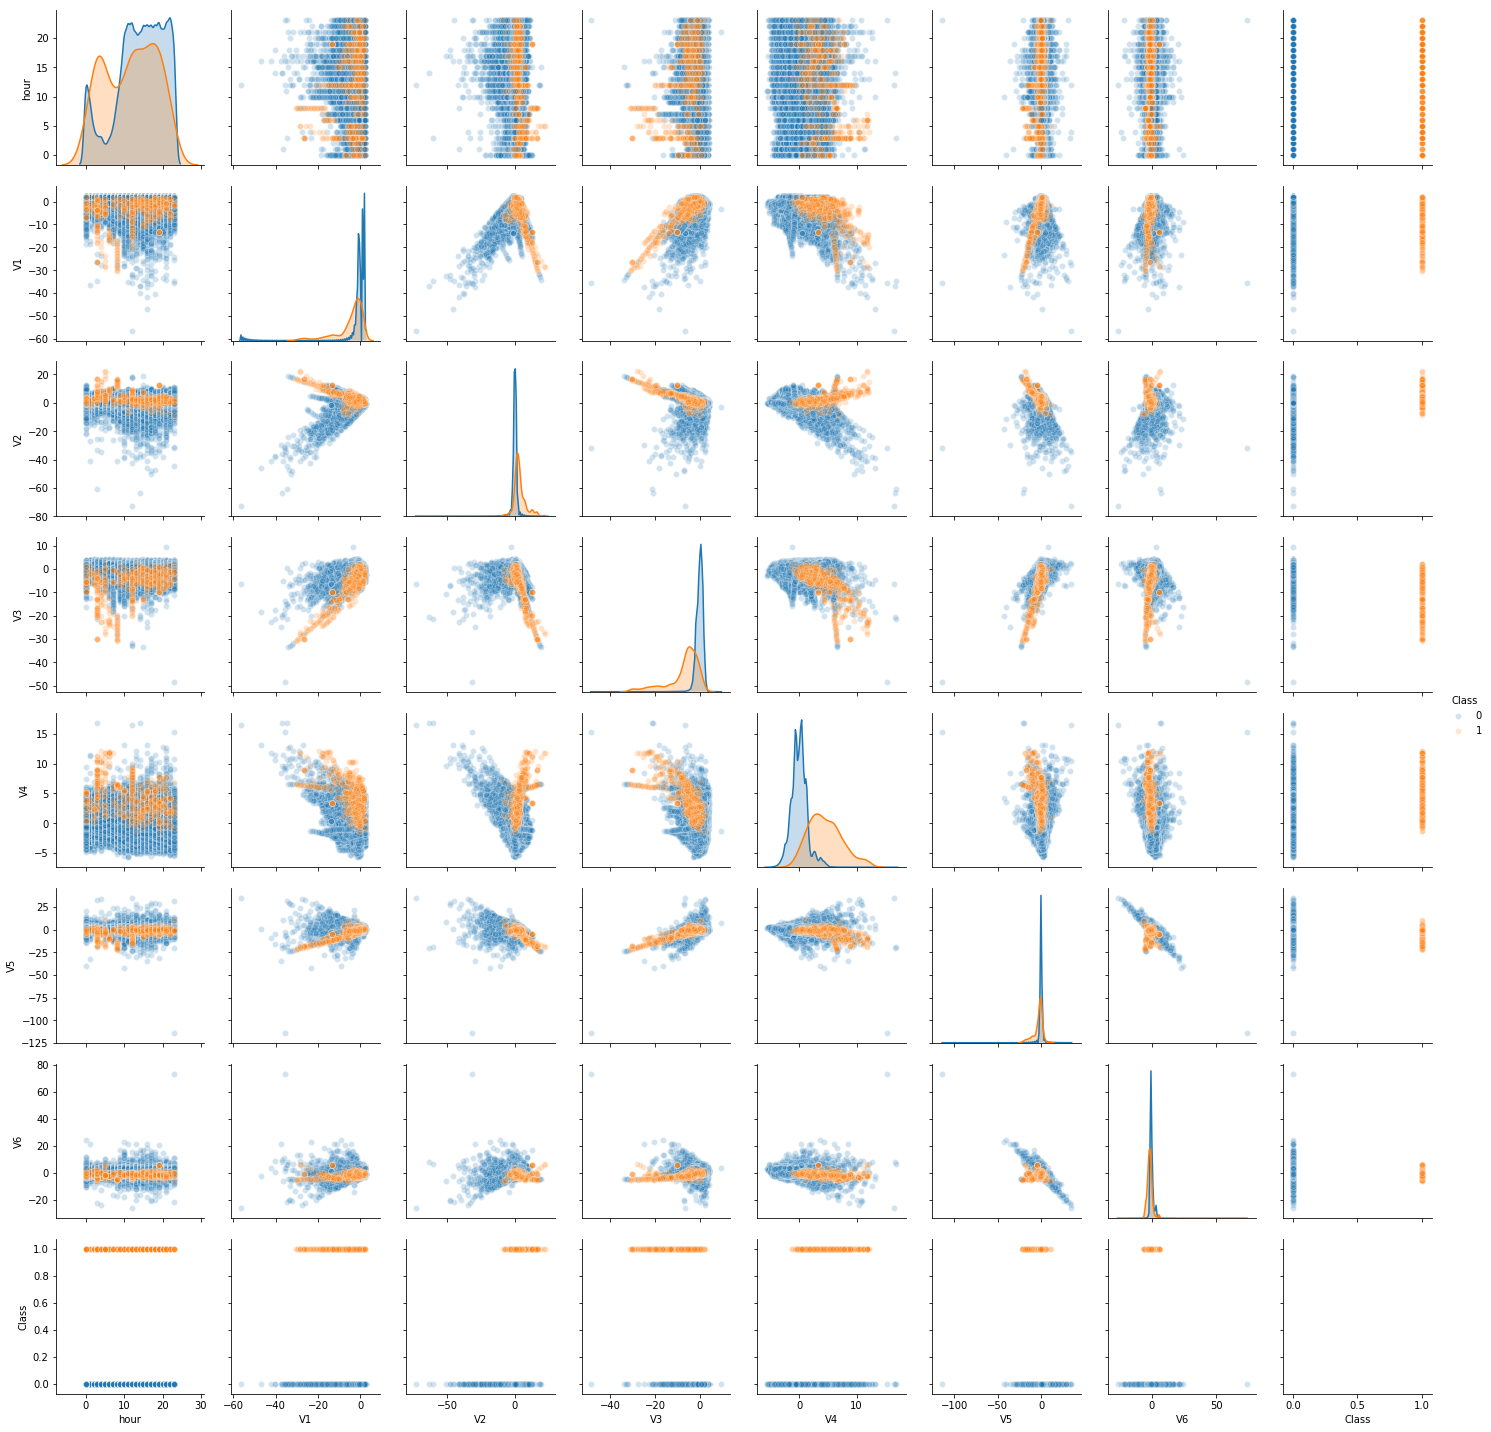

In [22]:
# Model building
# Let's start with a vanilla Logistic Regression since it seems like for some of the features, a sigmoid curve can sort of separate the classes.
sns.pairplot(data=pd.concat([df.loc[:,'hour'],df.loc[:,'V1':'V6'],df.loc[:,'Class']],axis=1),
             hue='Class',
             diag_kind='kde',
             plot_kws={'alpha':0.2})

Seems like most features show both Fraud and Legit purchases overlapping each other, with V4 showing a little promise. We can't rely on our eyes to do all the investigation work since we at most can make 4-dimensional charts (3 features + a color) to investigate our data, and our data has more than 30 features.

Let's get to model building and see how well our data can separate the classes.

# Model building
Let's start with a vanilla Logistic Regression since it seems like for some of the features, a sigmoid curve can sort of separate the classes.

In [23]:
features = pd.concat([df.loc[:,'V1':'Amount'],df.loc[:,'Time']],axis=1)
target = df['Class']

x_train,x_test,y_train,y_test = train_test_split(features,target, stratify=target,test_size=0.35, random_state=1)

print('y_train class counts')
print(y_train.value_counts())
print('')
print('y_test class counts')
print(y_test.value_counts())


# Let's store our y_test legit and fraud counts for normalization purposes later on
y_test_legit = y_test.value_counts()[0]
y_test_fraud = y_test.value_counts()[1]

y_train class counts
0    184804
1       320
Name: Class, dtype: int64

y_test class counts
0    99511
1      172
Name: Class, dtype: int64


In [24]:
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

pred = lr_model.predict(x_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


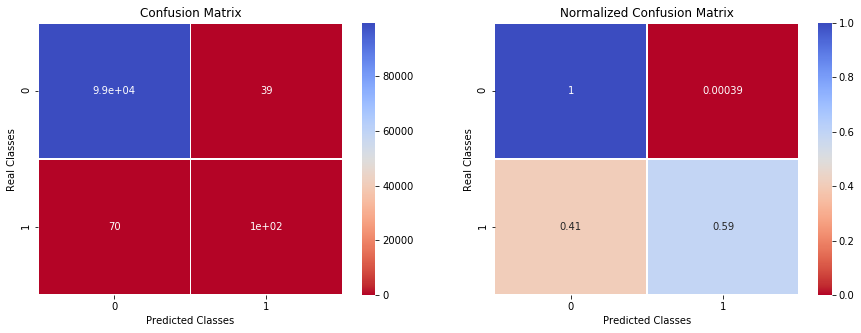

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.72      0.59      0.65       172

    accuracy                           1.00     99683
   macro avg       0.86      0.80      0.83     99683
weighted avg       1.00      1.00      1.00     99683



In [25]:
def PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud):

    cfn_matrix = confusion_matrix(y_test,pred)
    cfn_norm_matrix = np.array([[1.0 / y_test_legit,1.0/y_test_legit],[1.0/y_test_fraud,1.0/y_test_fraud]])
    norm_cfn_matrix = cfn_matrix * cfn_norm_matrix

    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,2,1)
    sns.heatmap(cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)
    plt.title('Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')

    ax = fig.add_subplot(1,2,2)
    sns.heatmap(norm_cfn_matrix,cmap='coolwarm_r',linewidths=0.5,annot=True,ax=ax)

    plt.title('Normalized Confusion Matrix')
    plt.ylabel('Real Classes')
    plt.xlabel('Predicted Classes')
    plt.show()
    
    print('---Classification Report---')
    print(classification_report(y_test,pred))

PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

I'm not a huge fan of confusion matrix because they can be misleading. I almost ALWAYS go directly to my classification report for precision and recall scores for each class. And Seaborn's heatmap coloring scheme is not helping. Our True Positive rate is 0.59 as also shown in the classification report which is not TOO bad, but it's shown as blood red. The normalized confusion matrix tells a better story. But, actual precision and recall scores are my go-to metrics.

It seems like we aren't very good with catching our frauds, which is expected with a vanilla Logistic Regression without addressing the class imbalance issue. 

# Addressing class imbalance
### Using weights to counteract the class imbalance
Sci-Kit Learn classifiers can give heavier weights to the minority class using a simple parameter during model initiation. Let's see how that will improve our results

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


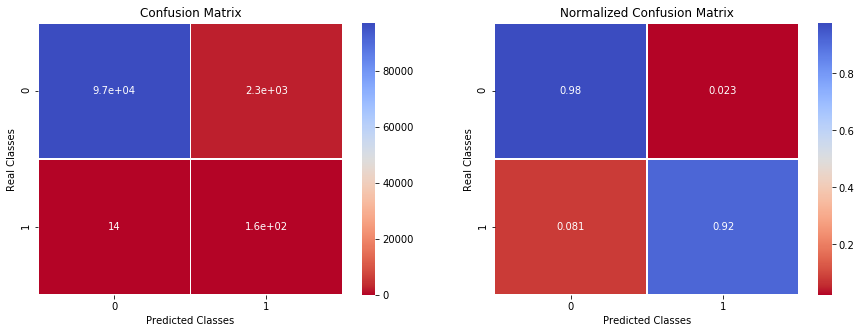

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99511
           1       0.06      0.92      0.12       172

    accuracy                           0.98     99683
   macro avg       0.53      0.95      0.55     99683
weighted avg       1.00      0.98      0.99     99683



In [26]:
lr_model = LogisticRegression(class_weight='balanced')
lr_model.fit(x_train,y_train)

pred = lr_model.predict(x_test)

PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

Looking at the normalized confusion matrix, it seems like our classifer is doing very well! We have a 98% True Negative rate and a 92% True Positive rate! Seems like a perfect classifer, doesn't it?

However, if we look at the individual precision scores, this classifer is now a lot less precise than before. This is because we have increased our Fraud recall score at the expense of more mis-classified Legit cases. With the "balanced" weight parameter, we have increased our false positive counts from 39 to 2300. 2300 is still only a small fraction of truely negative cases (out of 99511), that's why the percentage shown on the Normalized Confusion Matrix is still relatively small at 0.023%. Let's try to specify our own weights. The weights are somewhat arbitrary but it illustrates the tradeoff between precision and recall.

---Weight of 1 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


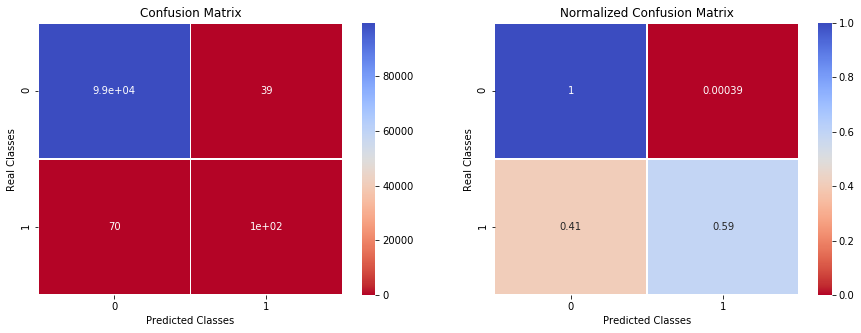

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.72      0.59      0.65       172

    accuracy                           1.00     99683
   macro avg       0.86      0.80      0.83     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 5 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


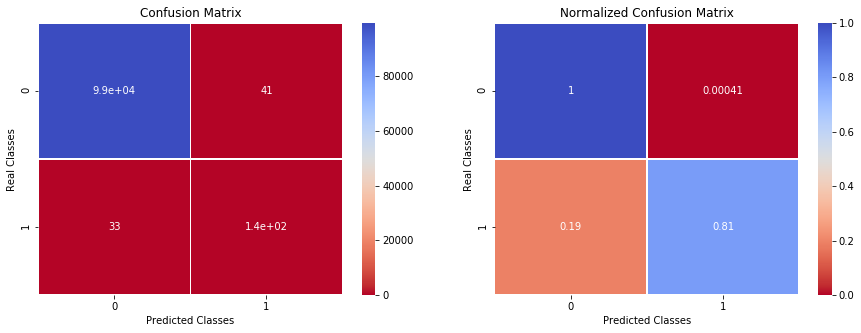

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.77      0.81      0.79       172

    accuracy                           1.00     99683
   macro avg       0.89      0.90      0.89     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 10 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


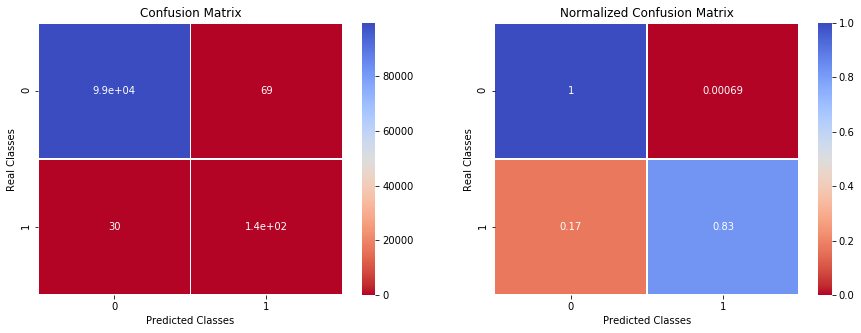

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.67      0.83      0.74       172

    accuracy                           1.00     99683
   macro avg       0.84      0.91      0.87     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 100 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


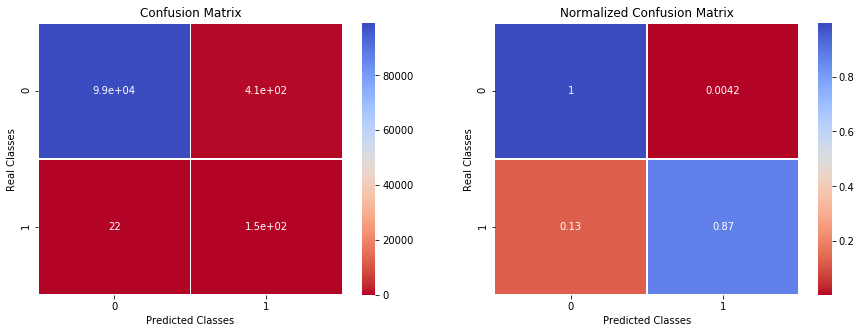

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99511
           1       0.27      0.87      0.41       172

    accuracy                           1.00     99683
   macro avg       0.63      0.93      0.70     99683
weighted avg       1.00      1.00      1.00     99683

---Weight of 500 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


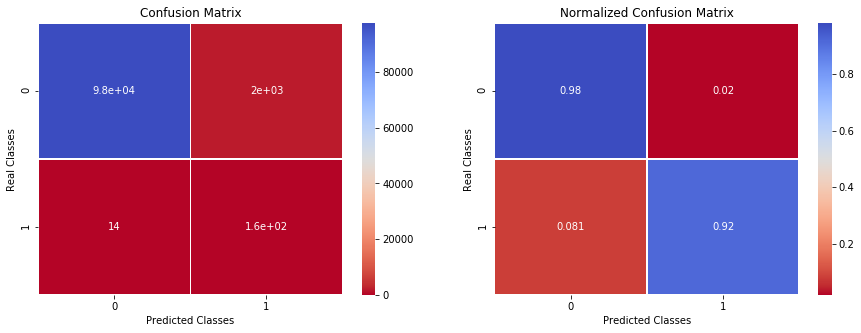

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99511
           1       0.07      0.92      0.14       172

    accuracy                           0.98     99683
   macro avg       0.54      0.95      0.56     99683
weighted avg       1.00      0.98      0.99     99683

---Weight of 1000 for Fraud class---


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


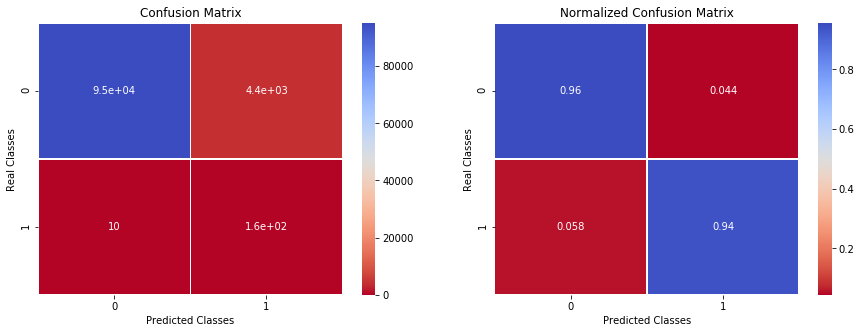

---Classification Report---
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     99511
           1       0.04      0.94      0.07       172

    accuracy                           0.96     99683
   macro avg       0.52      0.95      0.52     99683
weighted avg       1.00      0.96      0.98     99683



In [27]:
for w in [1,5,10,100,500,1000]:
    print('---Weight of {} for Fraud class---'.format(w))
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(x_train,y_train)

    pred = lr_model.predict(x_test)
    PlotConfusionMatrix(y_test,pred,y_test_legit,y_test_fraud)

## ROC versus Precision/Recall Curves
Just by manaually selecting a range of weights to boost the minority class already helped our model have better recall, and in some cases, better precision also. Recall and Precision are usually trade offs of each other, so when you can improve both **at the same time**, your model's overall performance is undeniably improved. 


To illustrate the trade off between precision vs recall, and let's also include False Positive Rate vs True Positive Rate (ROC), let's plot the ROC and Precision/Recall curves for different weights for the minority class.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

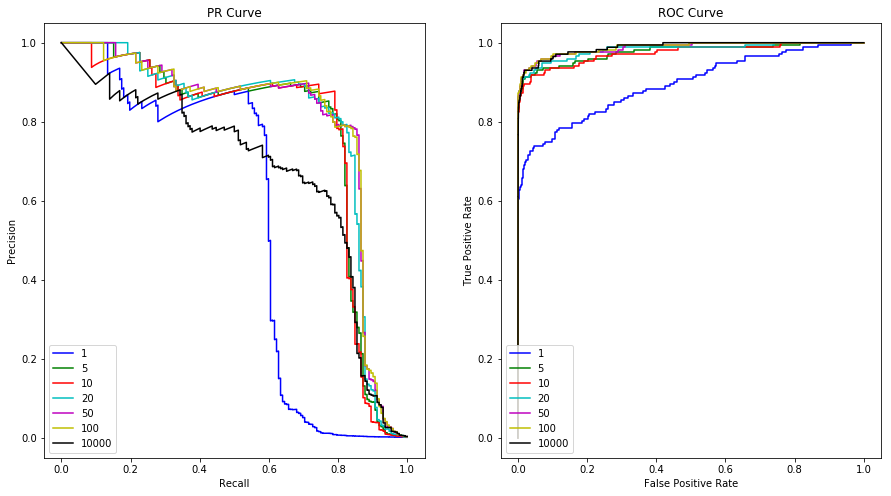

In [28]:
fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(1,2,1)
ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve')

ax2 = fig.add_subplot(1,2,2)
ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')

for w,k in zip([1,5,10,20,50,100,10000],'bgrcmykw'):
    lr_model = LogisticRegression(class_weight={0:1,1:w})
    lr_model.fit(x_train,y_train)
    pred_prob = lr_model.predict_proba(x_test)[:,1]

    p,r,_ = precision_recall_curve(y_test,pred_prob)
    tpr,fpr,_ = roc_curve(y_test,pred_prob)
    
    ax1.plot(r,p,c=k,label=w)
    ax2.plot(tpr,fpr,c=k,label=w)
ax1.legend(loc='lower left')    
ax2.legend(loc='lower left')

plt.show()

# Conclusion

For a PR curve, a good classifer aims for the upper right corner of the chart but upper left for the ROC curve.

While PR and ROC curves use the same data, i.e. the real class labels and predicted probability for the class lables, you can see that the two charts tell very different stories, with some weights seem to perform better in ROC than in the PR curve.

While the blue, w=1, line performed poorly in both charts, the black, w=10000, line performed "well" in the ROC but poorly in the PR curve. This is due to the high class imbalance in our data. ROC curve is not a good visual illustration for highly imbalanced data, because the False Positive Rate ( False Positives / Total Real Negatives ) does not drop drastically when the Total Real Negatives is huge.

Whereas Precision ( True Positives / (True Positives + False Positives) ) is highly sensitive to False Positives and is not impacted by a large total real negative denominator. 

The biggest difference among the models are at around 0.8 recall rate. Seems like a lower weight, i.e. 5 and 10, out performs other weights significantly at 0.8 recall. This means that with those specific weights, our model can detect frauds fairly well (catching 80% of fraud) while not annoying a bunch of customers with false positives with an equally high precision of 80%.

Without further tuning our model, and of course we should do cross validation for any real model tuning/validation, it seems like a vanilla Logistic Regression is stuck at around 0.8 Precision and Recall. 

So how do we know if we should sacrifice our precision for more recall, i.e. catching fraud? That is where data science meets your core business parameters. If the cost of missing a fraud highly outweighs the cost of canceling a bunch of legit customer transactions, i.e. false positives, then perhaps we can choose a weight that gives us a higher recall rate. Or maybe catching 80% of fraud is good enough for your business if you can minimize also minimize the "user friction" or credit card disruptions by keeping our precision high.

### End of notebook.